In [1]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import gym
from gym import spaces
from gym.utils import seeding
from agent import *
import numpy as np
import scipy
from scipy import stats
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

price is based on the on official pricing from the state electrical company (found [here](https://www.iec.co.il/content/tariffs/contentpages/taozb-namuch)) for 2025 and it is as:

summer (steps 145-267) : high 168.95 per unit (kwh), low 52.83 per unit.

winter (steps 1-58) : high 120.71 per unit (kwh), low 45.57 per unit.

fall and spring (268-365 and 52-144): high 49.77 per unit (kwh), low 44.60 per unit.

we our also going to assume that the agent is in charge of a generic household, meaning if currently the demand from the household is high, so will be the demand from everyone and as such the price will be high.

In [2]:
# Assuming household_power_consumption.txt is in the current directory
try:
    df = pd.read_csv('household_power_consumption.txt', sep=';',
                     parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True,
                     low_memory=False, na_values=['nan','?'])

    # Handle missing values (replace with 0 for demonstration, consider a more robust strategy)
    df.fillna(0, inplace=True)

    # Convert 'Global_active_power' column to numeric
    df['Global_active_power'] = pd.to_numeric(df['Global_active_power'])

    # Group by day and calculate the mean of 'Global_active_power'
    daily_avg_power = df.groupby(df['datetime'].dt.date)['Global_active_power'].mean()

    print(daily_avg_power)
    # print(len(daily_avg_power))

except FileNotFoundError:
    print("Error: household_power_consumption.txt not found. Please upload the file.")
except pd.errors.EmptyDataError:
    print("Error: household_power_consumption.txt is empty.")
except pd.errors.ParserError:
    print("Error: Could not parse the file. Please check the file format.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


datetime
2006-12-16    3.053475
2006-12-17    2.354486
2006-12-18    1.530435
2006-12-19    1.157079
2006-12-20    1.545658
                ...   
2010-11-22    1.417733
2010-11-23    1.095511
2010-11-24    1.247394
2010-11-25    0.993864
2010-11-26    1.178230
Name: Global_active_power, Length: 1442, dtype: float64


In [3]:
def normalize_series(series):
    min_val = series.min()
    max_val = series.max()

    if min_val == max_val:  # Handle cases where all values are the same
        return pd.Series([0.0] * len(series), index=series.index)

    normalized_series = (series - min_val) / (max_val - min_val)
    return normalized_series



normalized_power = normalize_series(daily_avg_power)
print(normalized_power)

# print("daily_avg_power not found. Please run the previous code block to define the variable.")


datetime
2006-12-16    0.921150
2006-12-17    0.710284
2006-12-18    0.461690
2006-12-19    0.349059
2006-12-20    0.466283
                ...   
2010-11-22    0.427691
2010-11-23    0.330486
2010-11-24    0.376305
2010-11-25    0.299822
2010-11-26    0.355440
Name: Global_active_power, Length: 1442, dtype: float64


In [4]:
from datetime import datetime
normalized_power_df = pd.DataFrame.from_dict({'datetime': normalized_power.index, 'Global_active_power': normalized_power.values})
# change the datetime column to datetime format
normalized_power_df['datetime'] = pd.to_datetime(normalized_power_df['datetime'])


In [5]:
# Filter data for the year 2007
df_2007 = normalized_power_df[normalized_power_df['datetime'].dt.year == 2007]

# Group by day and calculate the mean of 'Global_active_power' for 2007
daily_avg_power_2007 = df_2007.groupby(df_2007['datetime'].dt.date)['Global_active_power'].mean()
daily_avg_power_2007 = daily_avg_power_2007.asfreq('D') # makes the series a time series.
print(daily_avg_power_2007)


from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(daily_avg_power_2007, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())


datetime
2007-01-01    0.575902
2007-01-02    0.265898
2007-01-03    0.212439
2007-01-04    0.682830
2007-01-05    0.568436
                ...   
2007-12-27    0.530483
2007-12-28    0.652169
2007-12-29    0.691114
2007-12-30    0.536080
2007-12-31    0.464354
Freq: D, Name: Global_active_power, Length: 365, dtype: float64
                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                  365
Model:                  ARIMA(5, 1, 0)   Log Likelihood                 287.883
Date:                 Wed, 12 Mar 2025   AIC                           -563.766
Time:                         16:18:07   BIC                           -540.383
Sample:                     01-01-2007   HQIC                          -554.473
                          - 12-31-2007                                         
Covariance Type:                   opg                                         
                 coef    std err  

In [6]:
class ElectricityMarketEnv(gym.Env):
    def __init__(self,demand_model, demand_data, demand_noise_factor=0.05, capacity=1.0, max_steps=365,seed=0,non_neg=False):
        super(ElectricityMarketEnv, self).__init__()

        # Battery capacity
        # self.seed = seed
        self._seed = seed
        self.capacity = capacity
        self.max_steps = max_steps
        self.current_step = 0
        self.demand_model = demand_model
        self.demand_data = demand_data
        self.demand_noise_factor = demand_noise_factor
        self.non_neg = non_neg

        # State variables
        self.soc = np.random.uniform(0, self.capacity)  # Initial SoC
        self.demand = self._generate_demand()  # Initial demand
        self.price = np.random.normal(0.5, 0.005)  # Initial price

        # Action space: Continuous between -capacity and capacity
        self.action_space = spaces.Box(low=-self.capacity, high=self.capacity, shape=(1,), dtype=np.float32)

        # Observation space: [SoC, Demand, Price]
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0]),
            high=np.array([self.capacity, np.inf, np.inf]),
            dtype=np.float32
        )
        self.seed(seed)
    def seed(self,seed=None):
        self.np_random, seed = seeding.np_random(seed)
        np.random.seed(seed)
        self._seed = seed
        return [seed]
    
    def step(self, action):
        action = np.clip(action, -self.capacity, self.capacity)[0]  # Ensure within limits
        reward = 0
        self.current_step += 1

        # Discharge scenario
        if action < 0:

            discharge_amount = min(-action, self.soc)  # Cannot discharge more than stored
            reward += (discharge_amount - self.demand) * self.price  # Only excess is rewarded,or if not discharged (or had enough charge) forced to buy more electricity.
            if self.non_neg:
                reward = max(0, reward)
            self.soc -= discharge_amount

        # Charge scenario
        elif action > 0:
            charge_amount = min(action, self.capacity - self.soc)
            # charge_amount = charge_amount-self.demand
            # print("thisa charging action",charge_amount)   # Cannot exceed capacity
            self.soc += charge_amount
            if self.soc < self.demand:
                
                    
                reward -= (self.demand-self.soc) * self.price #when charging the battery, we buy electricity from grid
                if self.non_neg:
                    reward = 0
            else:
              reward = 0
            if not self.non_neg:
                self.soc = max(0,self.soc-self.demand)

        # Update market conditions
        self.demand = self._generate_demand()  # New demand value
        self.price = self.generate_price()  # Stochastic price change

        # Get new state
        state = np.array([self.soc, self.demand, self.price], dtype=np.float32)

        # Define termination condition
        done = self.current_step >= self.max_steps
        if done:
            self.reset()

        return state, reward, done, {}

    def reset(self):
        self.soc = np.random.uniform(0, self.capacity)
        self.demand = self._generate_demand()
        self.price = self.generate_price()
        self.current_step = 0
        return np.array([self.soc, self.demand, self.price], dtype=np.float32)

    def render(self, mode='human'):
        print(f"SoC: {self.soc:.2f}, Demand: {self.demand:.2f}, Price: {self.price:.2f}")

    def _generate_demand(self,):
        """
        Predicts the next day's power consumption using the last 5 data points, adds noise,
        and appends the prediction to the dataset.

        Args:
            model_fit: The fitted ARIMA model.
            data: The time series data (pandas Series).
            noise_factor: The factor controlling the amount of noise added to the prediction.

        Returns:
            A tuple containing:
                - The updated time series data with the prediction appended.
                - The noised prediction for the next day.
        """
        last_five_values = self.demand_data.tail(5).values
        prediction = self.demand_model.predict(start=len(self.demand_data), end=len(self.demand_data))

        # Add noise to the prediction
        noise = np.random.normal(0, self.demand_noise_factor * prediction, 1)
        noised_prediction = prediction + noise

        # Append to the dataset
        next_day_index = self.demand_data.index[-1] + pd.Timedelta(days=1)
        self.demand_data = pd.concat([self.demand_data, pd.Series(noised_prediction[0], index=[next_day_index])])

        return noised_prediction[0]

    def bounded_sin(self,t, A, B, frequency=1, phase=0):
      """
      Compute a sinusoidal value at time t with a peak at A and a trough at B.

      Parameters:
      t (float): Time step input.
      A (float): Maximum peak.
      B (float): Minimum trough.
      frequency (float): Controls how fast the wave oscillates (default 1).
      phase (float): Phase shift in radians (default 0).

      Returns:
      float: The sinusoidal value at time t.
      """
      amplitude = (A - B) / 2
      offset = (A + B) / 2
      return amplitude * np.sin(2 * np.pi * frequency * t + phase) + offset

    def generate_price(self):
          max_summer = 168.95/168.95
          max_winter = 120.71/168.95
          min_summer = 52.83/168.95
          min_winter = 45.57/168.95
          max_misc = 49.77/168.95
          min_misc = 44.60/168.95

          # Determine the current season
          noise = np.random.normal(0, 0.05)  # Add some randomness
          if self.current_step in range(1,58):
            init_price = self.bounded_sin(self.current_step, max_winter, min_winter, frequency=0.1,phase=0)

            price = init_price*0.7 + self.demand * 0.3 + noise
            price = min(price, max_winter)
            price = max(price, min_winter)
          elif self.current_step in range(145,267):
            init_price = self.bounded_sin(self.current_step, max_summer, min_summer, frequency=0.1,phase=0)
            price = init_price*0.7 + self.demand * 0.3 + noise
            price = min(price, max_summer)
            price = max(price, min_summer)
          else:
            init_price = self.bounded_sin(self.current_step, max_misc, min_misc, frequency=0.1,phase=0)
            price = init_price*0.7 + self.demand * 0.3 + noise
            price = min(price, max_misc)
            price = max(price, min_misc)



          return price




In [7]:
# Create the environment
env = ElectricityMarketEnv(demand_model=model_fit,demand_data=daily_avg_power_2007,non_neg=True)

# Print environment properties
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

# Simulate a random trajectory
obs = env.reset()
env.render()
action = env.action_space.sample() # Take random action
obs, reward, done, info = env.step(action)
# print(f"Step {i + 1}:")
env.render()
print(f"Action: {action}")
print(f"Reward: {reward}")
print(f"Done: {done}")



Observation Space: Box(0.0, [ 1. inf inf], (3,), float32)
Action Space: Box(-1.0, 1.0, (1,), float32)
SoC: 0.55, Demand: 0.59, Price: 0.29
SoC: 0.14, Demand: 0.48, Price: 0.65
Action: [-0.40884408]
Reward: 0
Done: False


In [8]:
def evaluate_model(model, env, num_trajectories=10):
    """
    Evaluates a given model in the environment over multiple trajectories.

    Args:
        model: The trained RL model.
        env: The environment to evaluate the model in.
        num_trajectories: The number of trajectories to run.

    Returns:
        A tuple containing the average reward and standard deviation across all trajectories.
    """

    rewards = []
    for _ in range(num_trajectories):
        obs = env.reset()
        total_reward = 0
        done = False

        while not done:
            action, _ = model.predict(obs)  # Use the model to predict actions
            obs, reward, done, _ = env.step(action)
            total_reward += reward

        rewards.append(total_reward)

    return np.mean(rewards), np.std(rewards)


In [9]:
def set_seed(seed=42):
    # random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:

for s in [0,10,20,30,40,50,60,70,80,90]:
    set_seed(s)
    env = ElectricityMarketEnv(demand_model=model_fit,demand_data=daily_avg_power_2007,non_neg=True,seed=s)
    agent = PPO_Agent(env, weighy_path=f"PPO_policy_{s}.pth",device=device)
    rewards = agent.train(num_episodes=50)
    with open(f"rewards_seed_{s}.pkl", "wb") as f:
        pickle.dump(rewards, f)

    # avg_reward, std_reward = agent.evaluate()
    # print(f"Average reward: {avg_reward:.2f}, Std Dev: {std_reward:.2f}")
    del env
    del agent
    # del avg_reward
    # del std_reward
    del rewards


for s in [0,10,20,30,40,50,60,70,80,90]:
    set_seed(s)
    env = ElectricityMarketEnv(demand_model=model_fit,demand_data=daily_avg_power_2007,non_neg=False,seed=s)
    agent = PPO_Agent(env, weighy_path=f"PPO_policy_none_neg_false_{s}.pth",device=device)
    rewards = agent.train(num_episodes=50)
    with open(f"rewards_seed_none_neg_false_{s}.pkl", "wb") as f:
        pickle.dump(rewards, f)
    # avg_reward, std_reward = agent.evaluate()
    # print(f"Average reward: {avg_reward:.2f}, Std Dev: {std_reward:.2f}")
    del env
    del agent
    # del avg_reward
    # del std_reward
    del rewards


Episode 0, Total Reward: 3.47


KeyboardInterrupt: 

In [ ]:
none_neg = np.zeros((10,50))
neg = np.zeros((10,50))
for k in range(0,100,10):
    with open(f"rewards_seed_{k}.pkl", "rb") as f:
        rewards = pickle.load(f)
        none_neg[k//10] = np.array([v.item() for v in rewards])
    with open(f"rewards_seed_none_neg_false_{k}.pkl", "rb") as f:
        rewards = pickle.load(f)
        neg[k//10] = np.array([v.item() for v in rewards])


In [ ]:
mean_per_episode_none_neg = np.mean(none_neg, axis=0)
mean_per_episode_neg = np.mean(neg, axis=0)

In [ ]:

def calculate_confidence_intervals(data, confidence=0.95, num_bootstrap_samples=1000):
    """
    Calculate both regular confidence interval and bootstrap percentile confidence interval.

    Args:
        data (array-like): The data for which to calculate the confidence intervals.
        confidence (float): The confidence level for the intervals.
        num_bootstrap_samples (int): The number of bootstrap samples to use for the bootstrap percentile interval.

    Returns:
        tuple: A tuple containing the regular confidence interval and the bootstrap percentile confidence interval.
    """
    # Regular confidence interval
    mean = np.mean(data)
    sem = stats.sem(data)
    regular_ci = stats.t.interval(confidence, len(data)-1, loc=mean, scale=sem)

    # Bootstrap percentile confidence interval
    bootstrap_samples = np.random.choice(data, (num_bootstrap_samples, len(data)), replace=True)
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    lower_percentile = (1 - confidence) / 2 * 100
    upper_percentile = (1 + confidence) / 2 * 100
    bootstrap_ci = np.percentile(bootstrap_means, [lower_percentile, upper_percentile])

    return regular_ci, bootstrap_ci

In [ ]:
regular_ci_none_neg = np.zeros((2, 50))
bootstrap_ci_none_neg = np.zeros((2, 50))
regular_ci_neg = np.zeros((2, 50))
bootstrap_ci_neg = np.zeros((2, 50))

for i in range(50):
    regular_ci_none_neg[:, i], bootstrap_ci_none_neg[:, i] = calculate_confidence_intervals(none_neg[:, i])
    regular_ci_neg[:, i], bootstrap_ci_neg[:, i] = calculate_confidence_intervals(neg[:, i])


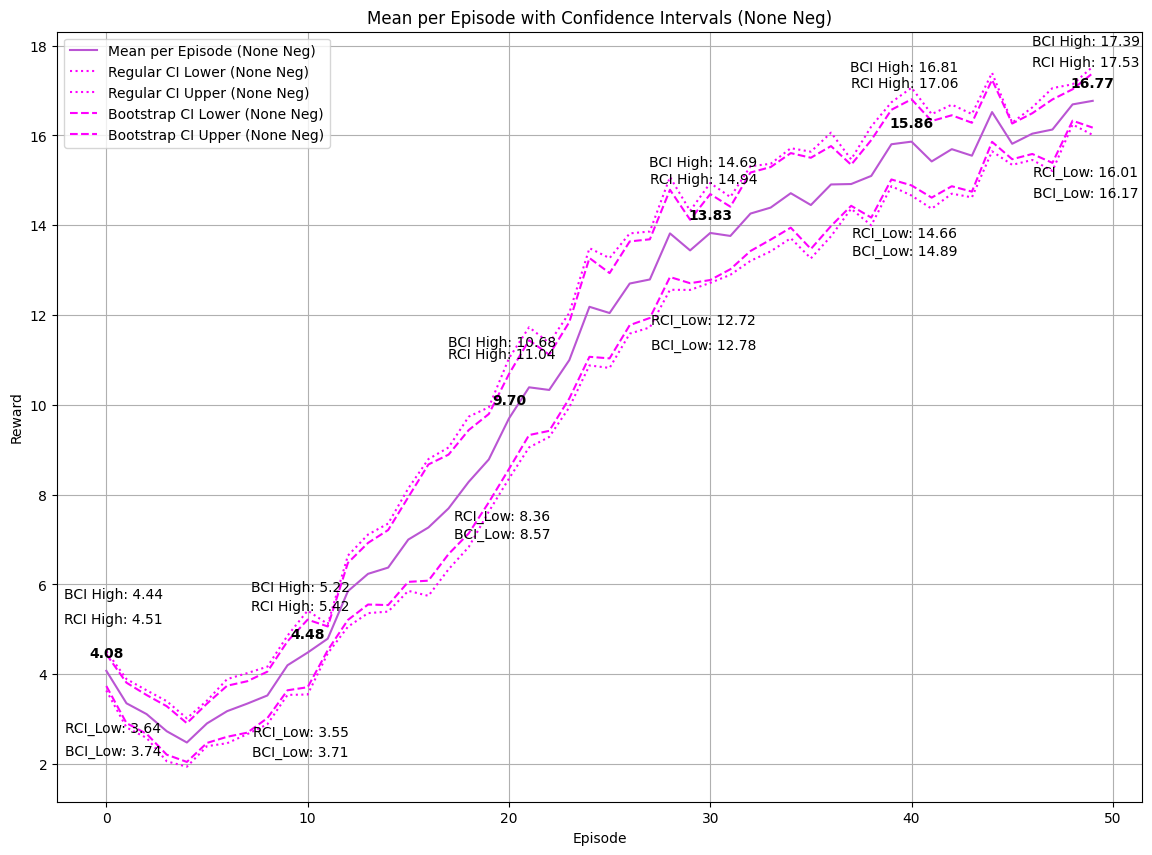

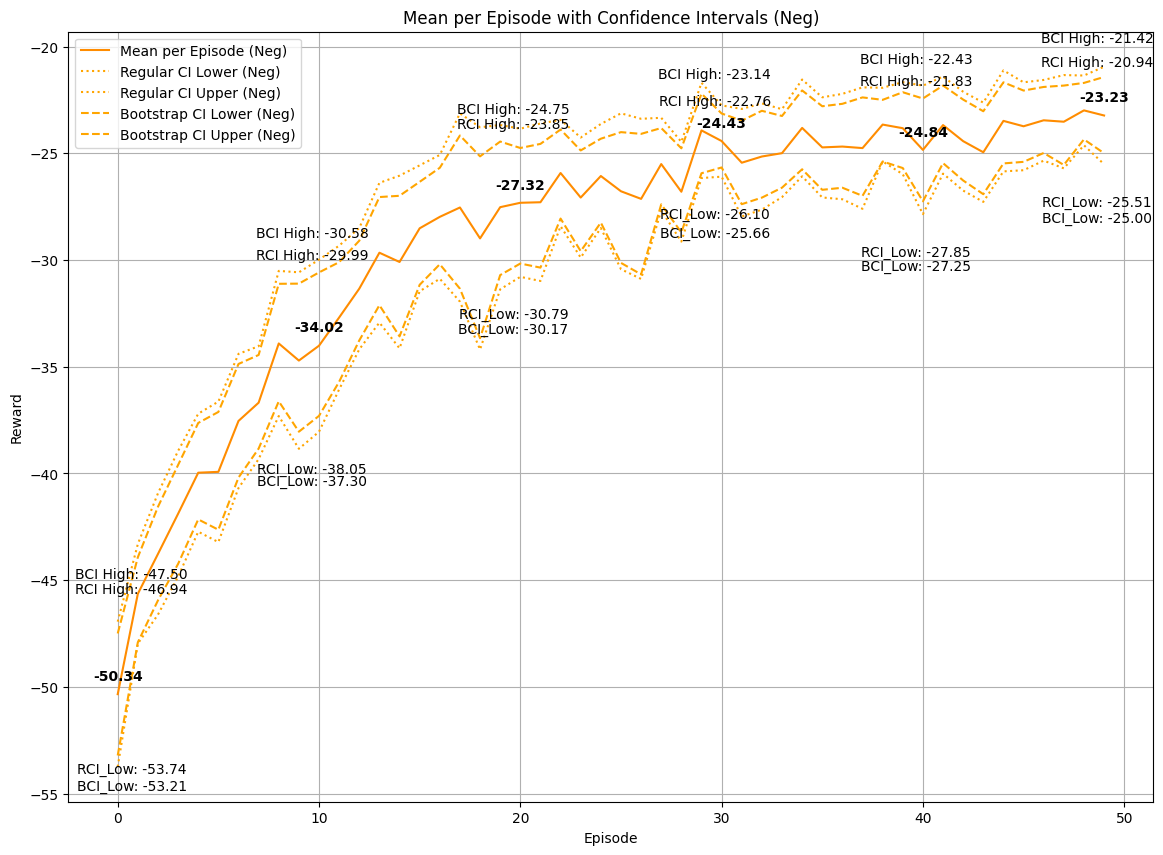

In [ ]:
import matplotlib.pyplot as plt

# Plot for none_neg
plt.figure(figsize=(14, 10))

# Plot mean per episode
plt.plot(mean_per_episode_none_neg, label='Mean per Episode (None Neg)', color='mediumorchid')

# Plot regular confidence intervals
plt.plot(regular_ci_none_neg[0], linestyle=':', color='fuchsia', label='Regular CI Lower (None Neg)')
plt.plot(regular_ci_none_neg[1], linestyle=':', color='fuchsia', label='Regular CI Upper (None Neg)')

# Plot bootstrap confidence intervals
plt.plot(bootstrap_ci_none_neg[0], linestyle='--', color='fuchsia', label='Bootstrap CI Lower (None Neg)')
plt.plot(bootstrap_ci_none_neg[1], linestyle='--', color='fuchsia', label='Bootstrap CI Upper (None Neg)')

# Annotate every ten episodes
for i in [0,10,20,30,40,49]:
    plt.annotate(f'{mean_per_episode_none_neg[i]:.2f}', (i, mean_per_episode_none_neg[i]), textcoords="offset points", xytext=(0,10), ha='center', color='black',fontweight ='bold')
    plt.annotate(f'RCI_Low: {regular_ci_none_neg[0, i]:.2f}', (i, regular_ci_none_neg[0, i]), textcoords="offset points", xytext=(-5,-30) if i !=0 else (5,-30), ha='center', color='black')
    plt.annotate(f'RCI High: {regular_ci_none_neg[1, i]:.2f}', (i, regular_ci_none_neg[1, i]), textcoords="offset points", xytext=(-5,0) if i !=0 else (5,20), ha='center', color='black')
    plt.annotate(f'BCI_Low: {bootstrap_ci_none_neg[0, i]:.2f}', (i, bootstrap_ci_none_neg[0, i]), textcoords="offset points", xytext=(-5,-50) if i !=0 else (5,-50), ha='center', color='black')
    plt.annotate(f'BCI High: {bootstrap_ci_none_neg[1, i]:.2f}', (i, bootstrap_ci_none_neg[1, i]), textcoords="offset points", xytext=(-5,20) if i !=0 else (5,40), ha='center', color='black')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Mean per Episode with Confidence Intervals (None Neg)')
plt.legend()
plt.grid(True)
plt.show()

# Plot for neg
plt.figure(figsize=(14, 10))

# Plot mean per episode
plt.plot(mean_per_episode_neg, label='Mean per Episode (Neg)', color='darkorange')

# Plot regular confidence intervals
plt.plot(regular_ci_neg[0], linestyle=':', color='orange', label='Regular CI Lower (Neg)')
plt.plot(regular_ci_neg[1], linestyle=':', color='orange', label='Regular CI Upper (Neg)')

# Plot bootstrap confidence intervals
plt.plot(bootstrap_ci_neg[0], linestyle='--', color='orange', label='Bootstrap CI Lower (Neg)')
plt.plot(bootstrap_ci_neg[1], linestyle='--', color='orange', label='Bootstrap CI Upper (Neg)')

# Annotate every ten episodes
for i in [0,10,20,30,40,49]:
    plt.annotate(f'{mean_per_episode_neg[i]:.2f}', (i, mean_per_episode_neg[i]), textcoords="offset points", xytext=(0,10), ha='center', color='black',fontweight ='bold')
    plt.annotate(f'RCI_Low: {regular_ci_neg[0, i]:.2f}', (i, regular_ci_neg[0, i]), textcoords="offset points", xytext=(-5,-30) if i !=0 else (10,-5), ha='center', color='black')
    plt.annotate(f'RCI High: {regular_ci_neg[1, i]:.2f}', (i, regular_ci_neg[1, i]), textcoords="offset points", xytext=(-5,0) if i!=0 else (10,20), ha='center', color='black')
    plt.annotate(f'BCI_Low: {bootstrap_ci_neg[0, i]:.2f}', (i, bootstrap_ci_neg[0, i]), textcoords="offset points", xytext=(-5,-50) if i != 0 else (10,-25), ha='center', color='black')
    plt.annotate(f'BCI High: {bootstrap_ci_neg[1, i]:.2f}', (i, bootstrap_ci_neg[1, i]), textcoords="offset points", xytext=(-5,25) if i!=0 else (10,40), ha='center', color='black')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Mean per Episode with Confidence Intervals (Neg)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Function to run an agent through one episode of the environment with negative results turned off
def run_agent_episode(weights_file, seed):
    # Set the seed
    set_seed(seed)
    
    # Create the environment with negative results turned off
    env = ElectricityMarketEnv(demand_model=model_fit, demand_data=daily_avg_power_2007, non_neg=True, seed=seed)
    
    # Initialize the agent
    agent = PPO_Agent(env, weighy_path=weights_file)
    
    # Load the weights
    agent.policy.load_state_dict(torch.load(weights_file))
    
    # Run one episode
    state = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action, _ = agent.select_action(state)
        next_state, reward, done, _ = env.step([action])
        total_reward += reward
        state = next_state
    
    return total_reward

# List of weights files and corresponding seeds
weights_files = [f"PPO_policy_none_neg_false_{s}.pth" for s in range(0, 100, 10)]
seeds = range(0, 100, 10)
total_rewards = []
# Run each agent through one episode and print the total reward
for weights_file, seed in zip(weights_files, seeds):
    total_reward = run_agent_episode(weights_file, seed)
    total_rewards.append(total_reward)
print(np.mean(total_rewards))
print(np.std(total_rewards))  
neg_on_none_neg = np.array(total_rewards)  

14.521644783271165
0.8374526835575357


In [ ]:
def run_agent_episode(weights_file, seed):
    # Set the seed
    set_seed(seed)
    
    # Create the environment with negative results turned off
    env = ElectricityMarketEnv(demand_model=model_fit, demand_data=daily_avg_power_2007, non_neg=False, seed=seed)
    
    # Initialize the agent
    agent = PPO_Agent(env, weighy_path=weights_file)
    
    # Load the weights
    agent.policy.load_state_dict(torch.load(weights_file))
    
    # Run one episode
    state = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action, _ = agent.select_action(state)
        next_state, reward, done, _ = env.step([action])
        total_reward += reward
        state = next_state
    
    return total_reward
weights_files = [f"PPO_policy_{s}.pth" for s in range(0, 100, 10)]
seeds = range(0, 100, 10)
total_rewards = []
# Run each agent through one episode and print the total reward
for weights_file, seed in zip(weights_files, seeds):
    total_reward = run_agent_episode(weights_file, seed)
    total_rewards.append(total_reward)
print(np.mean(total_rewards))
print(np.std(total_rewards))  
none_neg_on_neg = np.array(total_rewards)

-29.502810082575404
4.280930219564169


In [ ]:

t_stat, p_value = stats.ttest_ind(neg_on_none_neg,none_neg[:,49])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -5.149425079524361
P-value: 6.726332588214486e-05


In [ ]:
t_stat, p_value = stats.ttest_ind(none_neg_on_neg,neg[:,49])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -3.5885476221232615
P-value: 0.0021000182499905265


In [ ]:
def calculate_bootstrap_percentiles(data, num_samples=10000, percentiles=[0.01, 0.001]):
    bootstrap_samples = np.random.choice(data, (num_samples, len(data)), replace=True)
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    percentile_values = np.percentile(bootstrap_means, [p * 100 for p in percentiles])
    return percentile_values

# Calculate bootstrap percentiles for the last column of neg
neg_last_column = neg[:, -1]
expected_percentile_lows_neg = calculate_bootstrap_percentiles(neg_last_column)

# Calculate bootstrap percentiles for the last column of none_neg
none_neg_last_column = none_neg[:, -1]
expected_percentile_lows_none_neg = calculate_bootstrap_percentiles(none_neg_last_column)

# Print the results
print(f"Expected 0.01 and 0.001 percentiles for neg: {expected_percentile_lows_neg}")
print(f"Expected 0.01 and 0.001 percentiles for none_neg: {expected_percentile_lows_none_neg}")


Expected 0.01 and 0.001 percentiles for neg: [-25.48517522 -26.05424961]
Expected 0.01 and 0.001 percentiles for none_neg: [16.03538554 15.81348443]
